This example code will download a 5 minute high frequency hydrophone clip in mseed file format from ocean observatories raw data repository or load a previously downloaded clip and then use obsspy to plot it and save it as a wave file 

To run this in Anaconda you may need to load an extra library if not already loaded. The first is obspy (obs for ocean bottom seismometers) as this knows how to load mseed files - a standard in seismic community - and how the high frequency hydrophone data is stored in on the raw data repository. See the note here on how to install the binaries here: https://github.com/obspy/obspy/wiki/Installation-via-Anaconda

This notebook is based on the workbook from Pete Cable - https://github.com/petercable/shared_notebooks/blob/master/antelope/Antelope_to_WAV.ipynb

In [34]:
from obspy import read
from obspy.core import UTCDateTime
import wave
from obspy import signal
from obspy.signal import freqattributes
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import blackman

import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# BE/Bi 103 Utilities from Justin
#import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh
from bokeh import io
bokeh.io.output_notebook()


%matplotlib inline
data_url = 'https://rawdata.oceanobservatories.org/files/RS01SBPS/PC01A/08-HYDBBA103/2017/08/21/OO-HYVM2--YDH-2017-08-21T12:00:00.000000.mseed'
localFileName = 'OO-HYVM2--YDH-2017-08-21T12:00:00.000000.mseed'

Loading BokehJS ...

You can download directly from OOI in the program via the url or to speed up development download the file and place it in the same directory as this notebook and then read the local file.

In [31]:
loadFromOOI=True

if loadFromOOI==True :
    stream = read(data_url)
else:
    stream = read(localFileName)  # Read Previoulsy Download local file for speed

# print some stats about this signal
stream

1 Trace(s) in Stream:
OO.HYVM2..YDH | 2017-08-21T11:00:00.000000Z - 2017-08-21T11:00:04.450547Z | 64000.0 Hz, 284836 samples

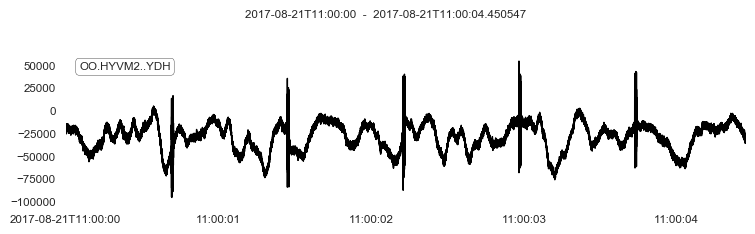

In [30]:
#Documentation about the obspy library is here https://docs.obspy.org/contents.html
# and list of things you can do with a stream now that its loaded is here
#https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html

#plot the entire 5 minute clip
stream.plot()

1 Trace(s) in Stream:
OO.HYVM2..YDH | 2017-08-21T11:00:00.000000Z - 2017-08-21T11:00:04.450547Z | 64000.0 Hz, 284836 samples


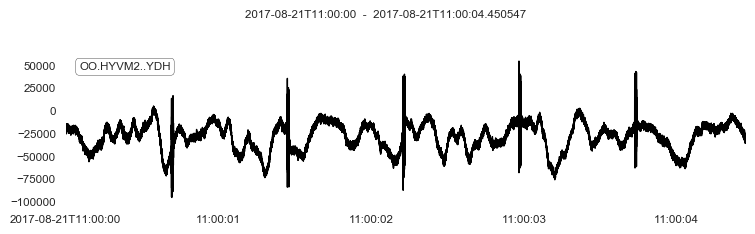

In [29]:
#zoom in and look at just 5 seconds - The spikes every 1/sec are from a co-located ADCP

dt = UTCDateTime("2017-08-21T11:00:00")
st = stream.slice(dt, dt + 480)
print(st)  
st.plot()

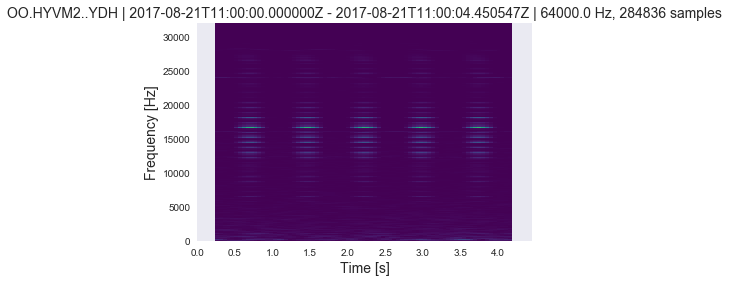

In [39]:
st[0].spectrogram()  

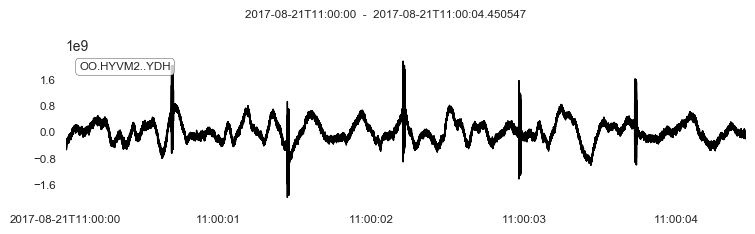

In [27]:
#lets convert it to something easy to play on a PC

trace = stream[0].copy()
trace.filter('highpass', freq=2.0)

#convert to full scale and then make 32 bit

trace.normalize()
trace.data = (trace.data * (2**31-1)).astype('int32')
trace.plot()

In [49]:
#write it to an audio file that can it can be played in like Audacity

trace.write('test.wav', format='WAV', framerate=64000)

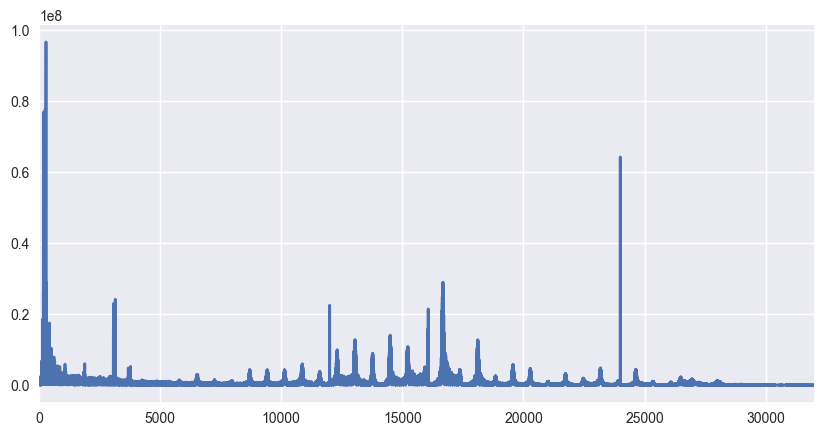

In [41]:
def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

def plotFFT(s):
    y = s[0].copy()
    N = len(s[0])
    Fs = getSamplingFreq(s)
    Y = fftshift(fft(y))
    f = fftshift(fftfreq(N, 1/Fs))
    Y = np.abs(np.transpose(Y))
    fig = plt.figure(figsize=(10, 5), dpi=100)
    plt.xlim(0,Fs/2)
    #plt.semilogy(f,Y)
    plt.plot(f,Y)
    plt.show()

st_filt = st.filter('highpass', freq=10.0)
plotFFT(st_filt)

In [19]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)
    
    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)
    
    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')
    
    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0;
            # initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)
                
    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

PCA took 0.345s.
t-SNE took 0.000s.


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:192: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


IndexError: index 1 is out of bounds for axis 1 with size 1

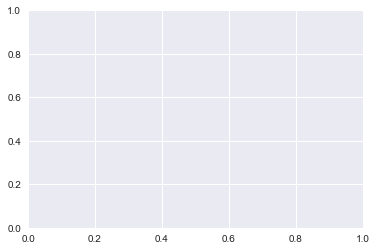

In [26]:
# Time the PCA computation
t0 = time()
# Use singular value decomposition to find eigenvalues and eigenvectors
digit_pca = sklearn.decomposition.TruncatedSVD(n_components=2)
# Transform the data
embed_pca = digit_pca.fit_transform(st_filt)
# Store the time
t_pca = time() - t0
# Print time 
print('PCA took %.3fs.' % t_pca)

# Time the tSNE computation
t0 = time()
# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_tsne = tsne.fit_transform(st_filt)
# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.3fs.' % t_tsne)

plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)